****EXPLORATIONS DATAV1****

In [1]:
# Importar bibliotecas necesarias
import os
from PIL import Image
import matplotlib.pyplot as plt

# Definir la ruta a las carpetas con las imagenes tomadas
folder1 = '../data/dataV1/images/grass'
folder2 = '../data/dataV1/images/ground'
folder3 = '../data/dataV1/images/sand'
folder4 = '../data/dataV1/images/val'


In [2]:

# Crear una lista para cada carpeta con los nombres de los archivos .jpg
files1 = [f for f in os.listdir(folder1) if f.endswith('.jpg')]
files2 = [f for f in os.listdir(folder2) if f.endswith('.jpg')]
files3 = [f for f in os.listdir(folder3) if f.endswith('.jpg')]
files4 = [f for f in os.listdir(folder4) if f.endswith('.jpg')]

# Crear un diccionario para almacenar el número de muestras por categoría
categories = {
    'grass': len(files1),
    'ground': len(files2),
    'sand': len(files3),
    'val': len(files4)
}


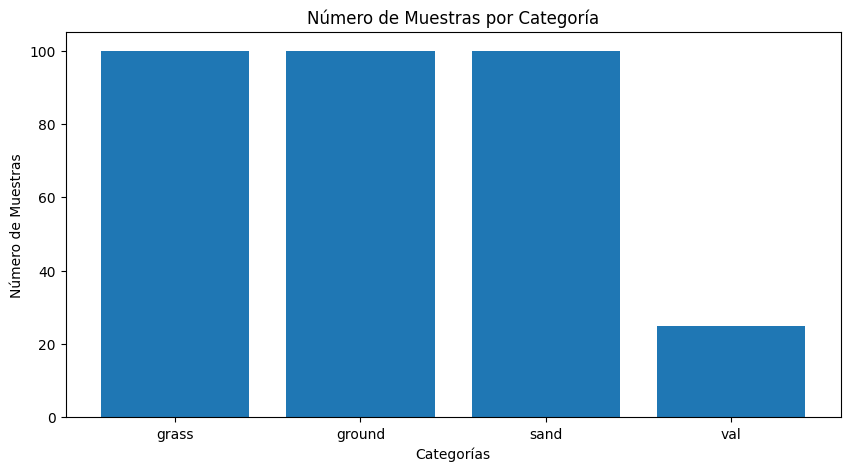

In [3]:

# Crear un gráfico de barras con el número de muestras por categoría
plt.figure(figsize=(10, 5))
plt.bar(categories.keys(), categories.values())
plt.xlabel('Categorías')
plt.ylabel('Número de Muestras')
plt.title('Número de Muestras por Categoría')
plt.show()


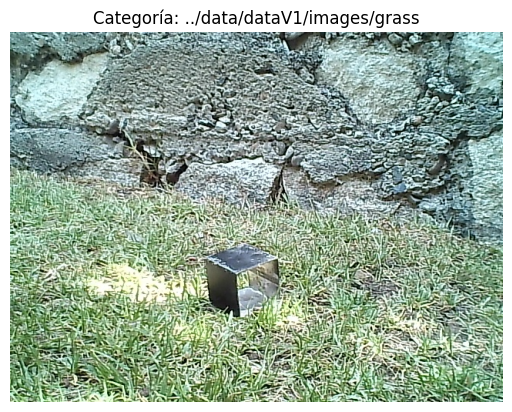

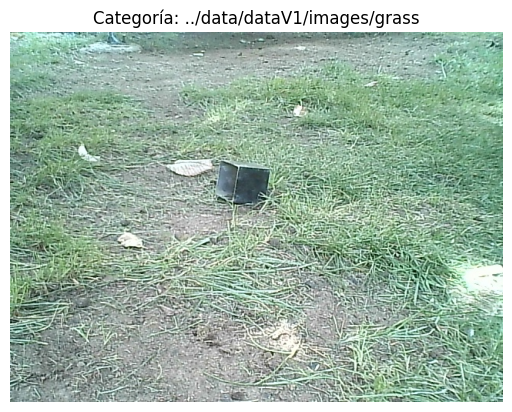

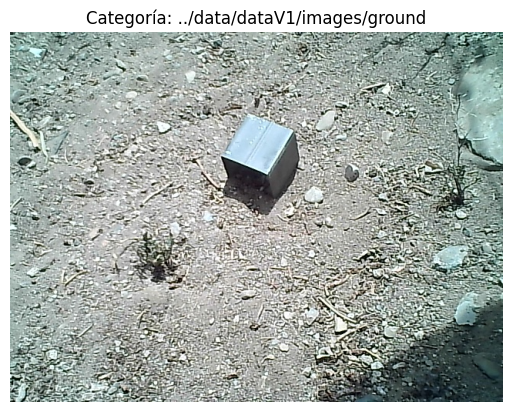

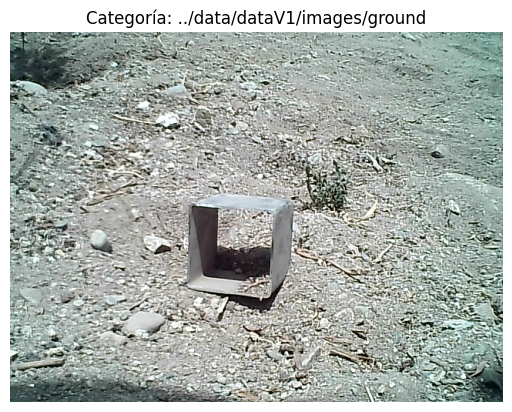

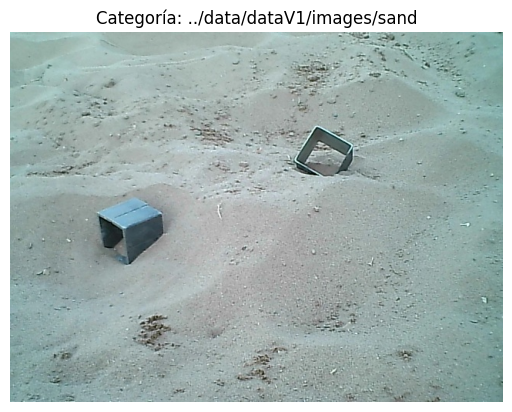

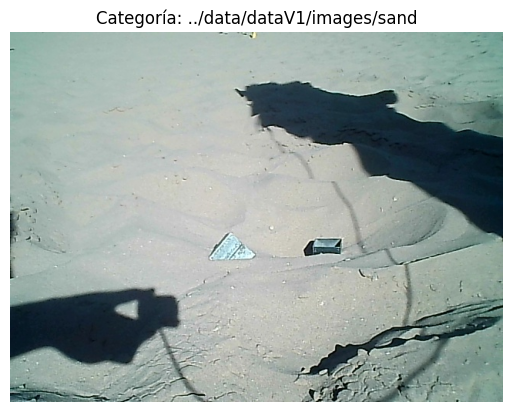

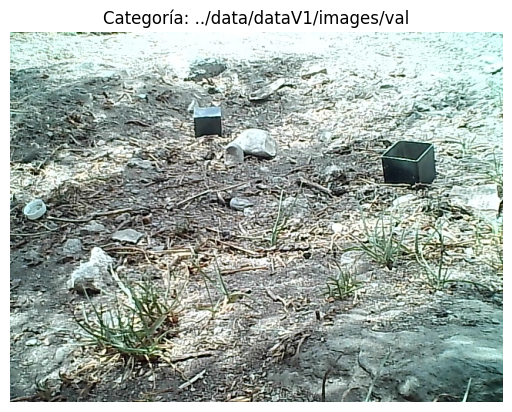

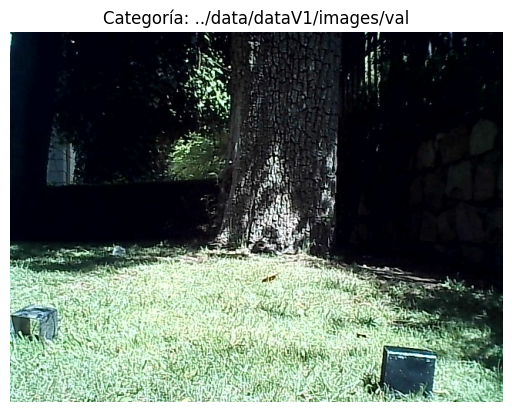

In [4]:
import random
# Función para mostrar una muestra aleatoria por categoría
def show_random_sample_images(folder, files, num_samples=1):
    random_files = random.sample(files, num_samples)
    for file in random_files:
        img = Image.open(os.path.join(folder, file))
        plt.figure()
        plt.imshow(img)
        plt.title(f'Categoría: {folder}')
        plt.axis('off')
        plt.show()
# Mostrar una o algunas muestras aleatorias por categoría
num_samples_per_category = 2 #2 samples
show_random_sample_images(folder1, files1, num_samples_per_category)
show_random_sample_images(folder2, files2, num_samples_per_category)
show_random_sample_images(folder3, files3, num_samples_per_category)
show_random_sample_images(folder4, files4, num_samples_per_category)


In [5]:

# Crear un diccionario para almacenar el número de imágenes por dimensión
dimensions = {}

# Función para obtener las dimensiones de una imagen
def get_image_dimensions(folder, files):
    for file in files:
        img = Image.open(os.path.join(folder, file))
        width, height = img.size
        dimensions[f'{width}x{height}'] = dimensions.get(f'{width}x{height}', 0) + 1

# Obtener el número de imágenes por dimensión
get_image_dimensions(folder1, files1)
get_image_dimensions(folder2, files2)
get_image_dimensions(folder3, files3)
get_image_dimensions(folder4, files4)


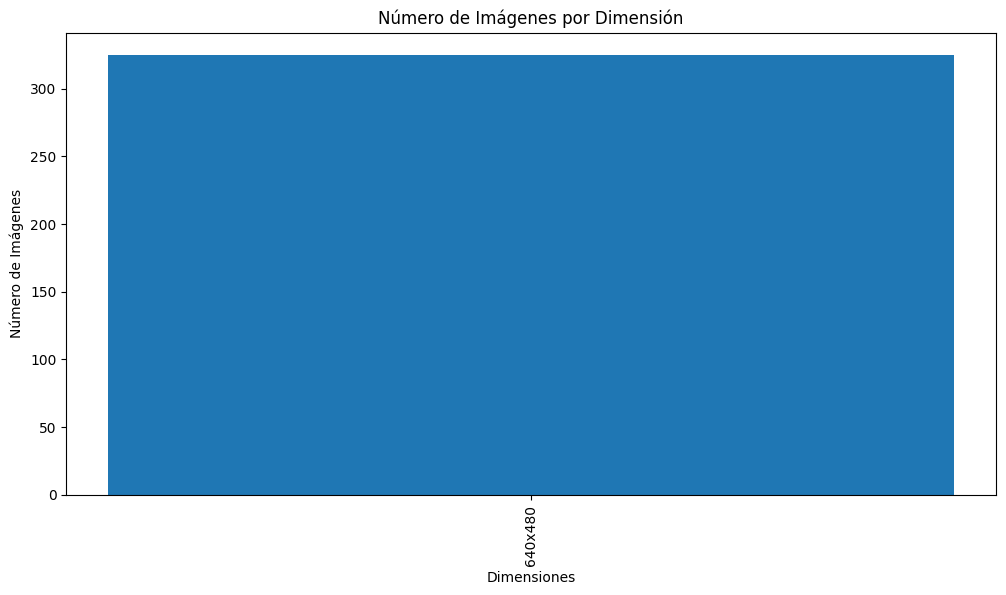

In [6]:
# Crear un gráfico de barras con el número de imágenes por dimensión diferente
plt.figure(figsize=(12, 6))
plt.bar(dimensions.keys(), dimensions.values())
plt.xticks(rotation=90)
plt.xlabel('Dimensiones')
plt.ylabel('Número de Imágenes')
plt.title('Número de Imágenes por Dimensión')
plt.show()

****GENERATE THE DATA PREPROCESSING FOR dataV1****

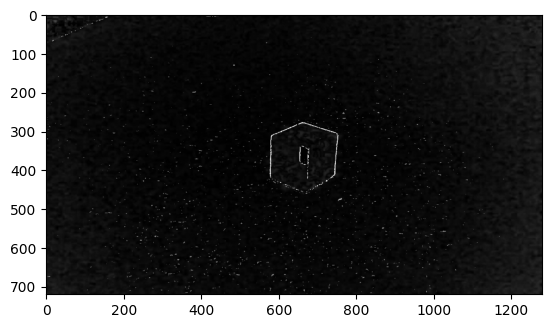

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocessing_img(input_dir, output_dir):
    def Cannycontours(imagen, u1, u2, b1, b2):
        img = cv2.GaussianBlur(imagen, (b1, b2), 0)
        Canny = cv2.Canny(img, u1, u2)
        return Canny

    def apply_dilation(imagen, dilation_iterations):
        kernel = np.ones((2, 2), np.uint8)
        dilation = cv2.dilate(imagen, kernel, iterations=dilation_iterations)
        return dilation

    def draw(imagen, imagenOR):
        contours, _ = cv2.findContours(imagen, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(imagenOR, contours, -1, (0, 255, 0), 2)
        return imagenOR, contours

    def detect(contour):
        perimeter = cv2.arcLength(contour, True)
        approximate = cv2.approxPolyDP(contour, .04 * perimeter, True)
        x, y, w, h = cv2.boundingRect(approximate)
        aspect_ratio = w / float(h)

        if ((len(approximate) == 6 or len(approximate) == 5) and (aspect_ratio >= 0.8 and aspect_ratio <= 1.5)):
            shape = 'CUBO'
        else:
            shape = ' '

        return shape, len(approximate), aspect_ratio

    frame = cv2.imread(input_dir)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    #frame = frame[200:700, 268:, :]

    #APLICACIÓN DE ECUALIZACIÓN

    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(69,69))#27 27

    canal_r, canal_g, canal_b = cv2.split(frame)
    canal_r_equalizado = clahe.apply(canal_r)
    canal_g_equalizado = clahe.apply(canal_g)
    canal_b_equalizado = clahe.apply(canal_b)
    frame = cv2.merge((canal_r_equalizado, canal_g_equalizado, canal_b_equalizado))

    #frame1 = cv2.cvtColor(frame, cv2.COLOR_RGB2YUV)
    frame2 = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)

    

    HSV = frame2
    H, S, V = cv2.split(HSV)
    # *Thresholding*
    #V = cv2.GaussianBlur(V, (3, 3), 0)
    mascara_binarizada = cv2.adaptiveThreshold(V, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 15, 30)
    V_binarizada = V * mascara_binarizada
    HSV_binarizado = cv2.merge([H, S, V_binarizada])
    #imagen_binarizada_bgr = cv2.cvtColor(HSV_binarizado, cv2.COLOR_HSV2RGB)
    h, s, v = cv2.split(HSV_binarizado)

    #ADICION DEL CANAL S
    s2 = s
    s2 = cv2.GaussianBlur(s2, (3, 3), 0)
    v2 = v
    factor_s = 0.35
    s2 = np.clip(s2 * factor_s, 0, 255).astype(np.uint8)
    suma_SV = cv2.add(v2, s2)
    imagen_gris = suma_SV
    

    
    #CANNY EDGE
    ImagenCanny = Cannycontours(imagen_gris, 10, 156, 7, 7)
    ImagenDilatation = apply_dilation(ImagenCanny, 3)

    edges = ImagenDilatation
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    image_rgb = frame
    con = 0
    for contour in contours:
        shape, count, ratio = detect(contour)
        if (shape == "CUBO"):
            con = con + 1
            cv2.drawContours(image_rgb, [contour], -1, (255, 255, 0), 2)
            cv2.putText(image_rgb, str(shape) + str(con), tuple(contour[0][0] + 40), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (255, 0, 0), 3)
            cv2.putText(image_rgb, str(count), tuple(contour[0][0] + 90), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (255, 0, 0), 3)
            cv2.putText(image_rgb, str(ratio), tuple(contour[0][0] + 130), cv2.FONT_HERSHEY_SIMPLEX, 1.3, (255, 0, 0), 3)

    cv2.imwrite(output_dir, imagen_gris, None)

    return imagen_gris,image_rgb

# Ejemplo
input_image_path = "dataTest/img6.jpg"
output_image_path = "dataTest/img6x.jpg"
resulting_image,_ = preprocessing_img(input_image_path, output_image_path)

plt.imshow(resulting_image,cmap="gray")
plt.show()


In [8]:
import os

# Define las rutas de las carpetas de entrada y salida para las 4 iteraciones
input_folders = ["../data/dataV1/images/grass", "../data/dataV1/images/ground", "../data/dataV1/images/sand", "../data/dataV1/images/val"]
output_folders = ["../data/dataV2/images/grass", "../data/dataV2/images/ground", "../data/dataV2/images/sand", "../data/dataV2/images/val"]

# Crea las carpetas de salida si no existen
for folder in output_folders:
    os.makedirs(folder, exist_ok=True)

# Itera sobre las carpetas
for i in range(4):
    input_folder = input_folders[i]
    output_folder = output_folders[i]
    
    # Obtiene la lista de archivos en la carpeta de entrada
    file_list = os.listdir(input_folder)

    for file_name in file_list:
        if file_name.endswith(".jpg"):
            input_path = os.path.join(input_folder, file_name)
            output_path = os.path.join(output_folder, file_name)

            _, processed_image = preprocessing_img(input_path, output_path)


****EXPLORATIONS DATAV2****

In [9]:
# Importar bibliotecas necesarias
import os
from PIL import Image
import matplotlib.pyplot as plt

# Definir la ruta a las carpetas con las imagenes tomadas
folder1 = '../data/dataV2/images/grass'
folder2 = '../data/dataV2/images/ground'
folder3 = '../data/dataV2/images/sand'
folder4 = '../data/dataV2/images/val'


In [10]:

# Crear una lista para cada carpeta con los nombres de los archivos .jpg
files1 = [f for f in os.listdir(folder1) if f.endswith('.jpg')]
files2 = [f for f in os.listdir(folder2) if f.endswith('.jpg')]
files3 = [f for f in os.listdir(folder3) if f.endswith('.jpg')]
files4 = [f for f in os.listdir(folder4) if f.endswith('.jpg')]

# Crear un diccionario para almacenar el número de muestras por categoría
categories = {
    'grass': len(files1),
    'ground': len(files2),
    'sand': len(files3),
    'val': len(files4)
}


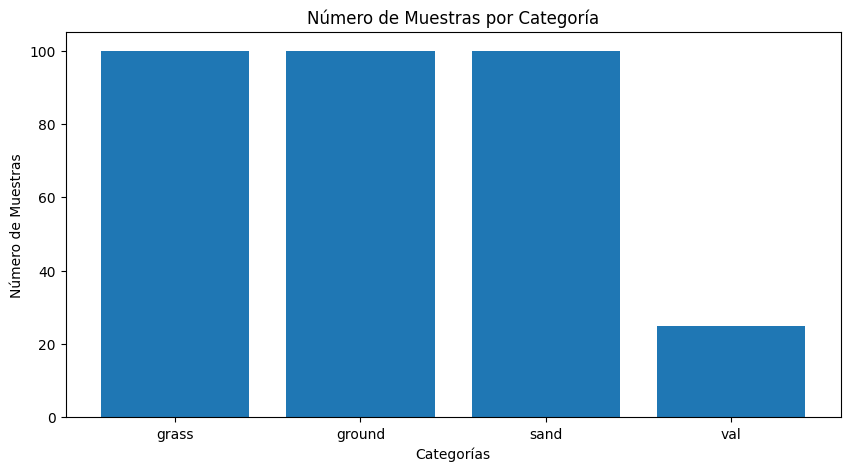

In [11]:

# Crear un gráfico de barras con el número de muestras por categoría
plt.figure(figsize=(10, 5))
plt.bar(categories.keys(), categories.values())
plt.xlabel('Categorías')
plt.ylabel('Número de Muestras')
plt.title('Número de Muestras por Categoría')
plt.show()


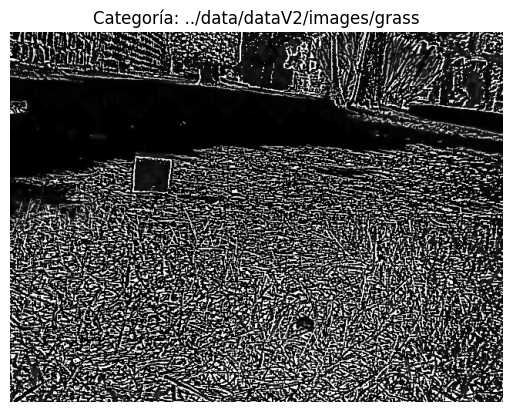

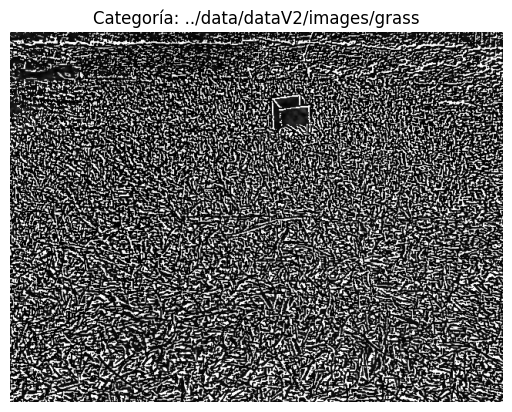

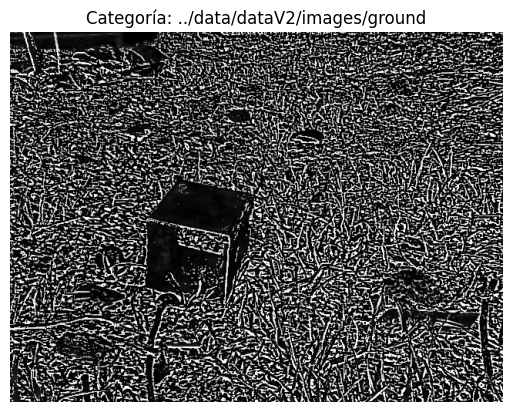

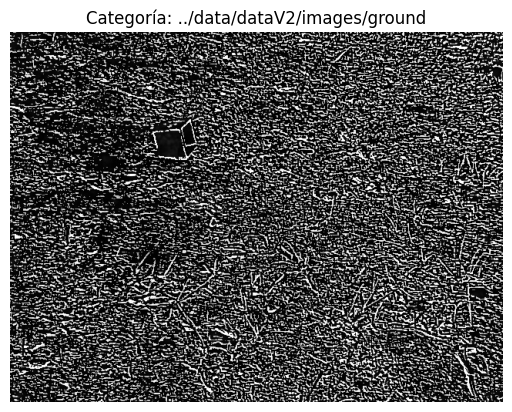

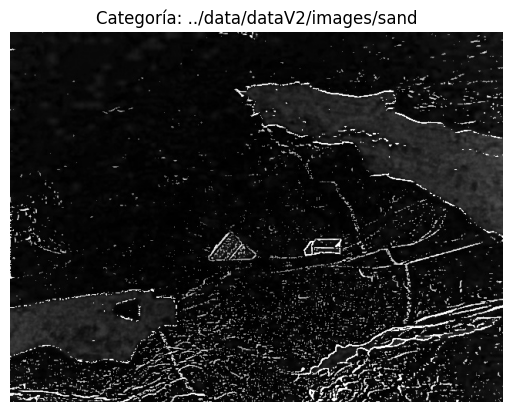

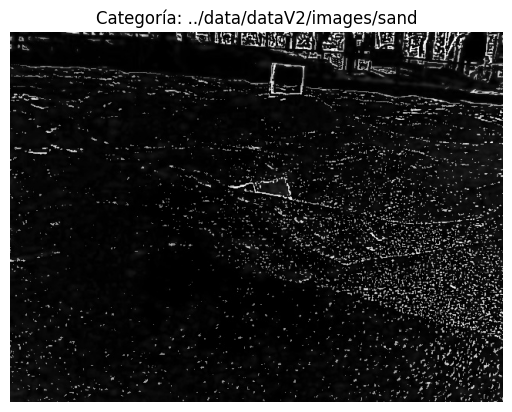

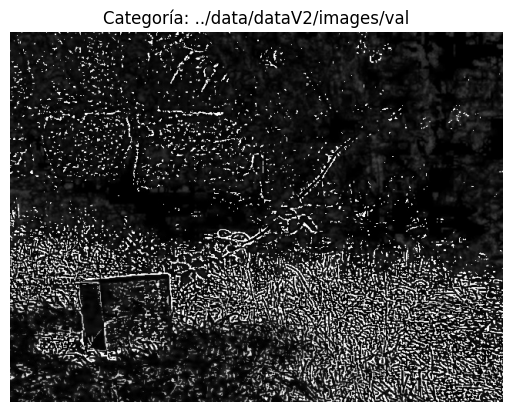

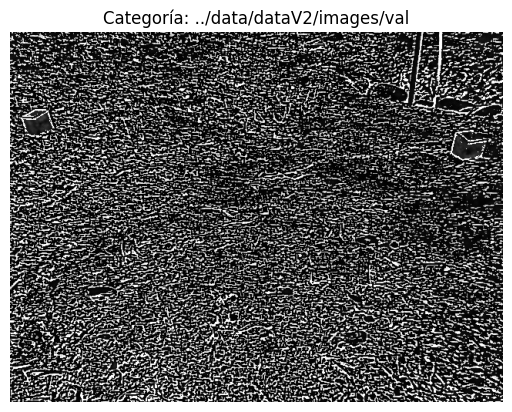

In [12]:
import random
# Función para mostrar una muestra aleatoria por categoría
def show_random_sample_images(folder, files, num_samples=1):
    random_files = random.sample(files, num_samples)
    for file in random_files:
        img = Image.open(os.path.join(folder, file))
        plt.figure()
        plt.imshow(img,cmap="gray")
        plt.title(f'Categoría: {folder}')
        plt.axis('off')
        plt.show()
# Mostrar una o algunas muestras aleatorias por categoría
num_samples_per_category = 2 #2 samples
show_random_sample_images(folder1, files1, num_samples_per_category)
show_random_sample_images(folder2, files2, num_samples_per_category)
show_random_sample_images(folder3, files3, num_samples_per_category)
show_random_sample_images(folder4, files4, num_samples_per_category)


In [13]:

# Crear un diccionario para almacenar el número de imágenes por dimensión
dimensions = {}

# Función para obtener las dimensiones de una imagen
def get_image_dimensions(folder, files):
    for file in files:
        img = Image.open(os.path.join(folder, file))
        width, height = img.size
        dimensions[f'{width}x{height}'] = dimensions.get(f'{width}x{height}', 0) + 1

# Obtener el número de imágenes por dimensión
get_image_dimensions(folder1, files1)
get_image_dimensions(folder2, files2)
get_image_dimensions(folder3, files3)
get_image_dimensions(folder4, files4)


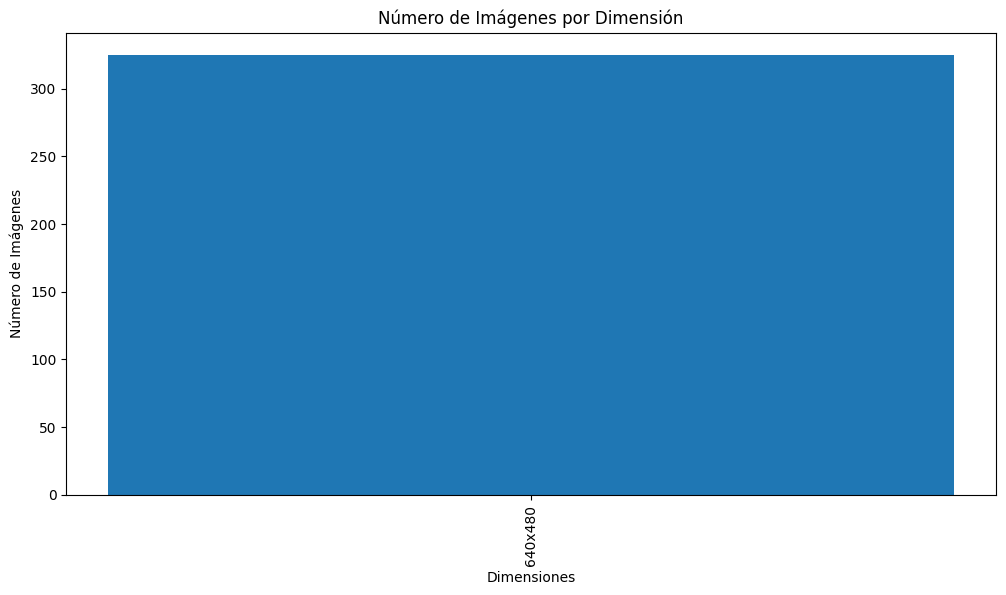

In [14]:
# Crear un gráfico de barras con el número de imágenes por dimensión diferente
plt.figure(figsize=(12, 6))
plt.bar(dimensions.keys(), dimensions.values())
plt.xticks(rotation=90)
plt.xlabel('Dimensiones')
plt.ylabel('Número de Imágenes')
plt.title('Número de Imágenes por Dimensión')
plt.show()